<a href="https://colab.research.google.com/github/JayYongjaeKim/MoLab/blob/main/Movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [ ]:
# 세션정의  *UA 기준으로 설정(30분)*

session_time_gap = 30 * 60 #초변환입니다.
data['Time'] = pd.to_datetime(data['Time'], unit='s')

data['Time_diff'] = data.groupby('UserId')['Time'].diff().dt.total_seconds()

data['SessionId'] = (data['Time_diff'] > session_time_gap).cumsum() #30분 기준으로 넘어가면 새로운sid 생성하는 GA기준입니다

In [ ]:
session_length = data.groupby('SessionId').size()

In [ ]:
print(session_length.describe())
print(session_length.median(), session_length.mean())

count    19124.000000
mean        52.301245
std        135.558375
min          1.000000
25%          1.000000
50%          3.000000
75%         32.000000
max       2411.000000
dtype: float64
3.0 52.301244509516835


In [ ]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

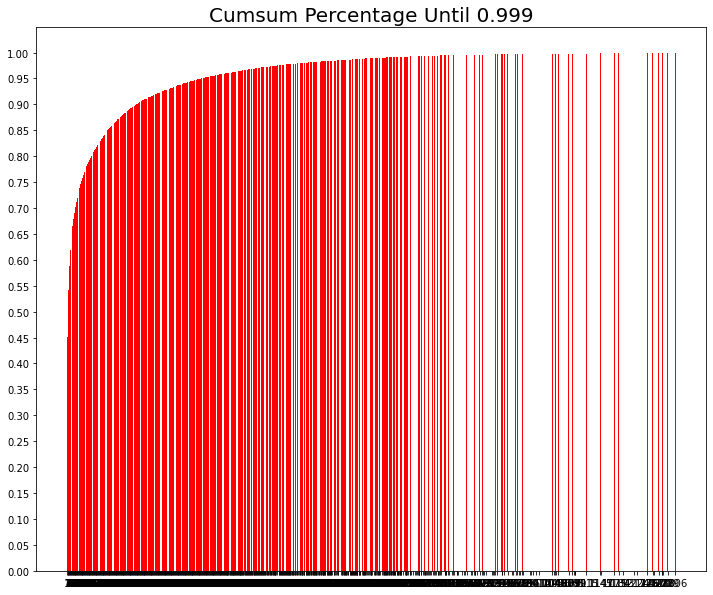

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [ ]:
latest = data['Time'].max()
latest = pd.to_datetime(latest, unit='s')

six_months_ago = latest - pd.Timedelta(days=6*30)

data_recent = data[data['Time'] > six_months_ago]

data2 = data_recent #원본 data는 살릴것 *6개월치

In [ ]:
data2

,UserId,ItemId,Rating,Time,Time_diff,SessionId
5200,36,2269,5,2002-12-22 08:05:50,24319448.0,53
5256,36,1701,4,2002-12-22 08:05:50,0.0,53
5184,36,2694,3,2002-12-22 08:08:14,144.0,53
5364,36,3786,4,2002-12-22 08:08:41,27.0,53
5262,36,2369,4,2002-12-22 08:09:24,43.0,53
...,...,...,...,...,...,...
984733,5950,1262,4,2003-02-27 18:17:38,121.0,18918
986778,5956,469,3,2002-09-30 03:54:57,7108568.0,18963
992702,5996,168,3,2002-09-03 13:12:26,10945521.0,19056
992459,5996,339,4,2002-10-07 13:24:39,2938333.0,19057


In [ ]:
def cleanse_short_session(data2, min_length=2):
    session_len = data2.groupby('SessionId').size()
    valid_sessions = session_len[session_len >= min_length].index
    return data2[data2['SessionId'].isin(valid_sessions)]

def cleanse_unpopular_item(data2, min_clicks=5):
    item_clicks = data2.groupby('ItemId').size()
    popular_items = item_clicks[item_clicks >= min_clicks].index
    return data2[data2['ItemId'].isin(popular_items)]

def cleanse_recursive(data2, min_length=2, min_clicks=5):
    while True:
        before = len(data2)
        data2 = cleanse_short_session(data2, min_length)
        data2 = cleanse_unpopular_item(data2, min_clicks)
        after = len(data2)
        if before == after:
            break
    return data2

data2 = cleanse_recursive(data2)

# 클릭횟수가 5미만인것 제외(인기 없음), 길이가 1인 세션 제거

In [ ]:
data2 #8823 > 4685

,UserId,ItemId,Rating,Time,Time_diff,SessionId
5364,36,3786,4,2002-12-22 08:08:41,27.0,53
5262,36,2369,4,2002-12-22 08:09:24,43.0,53
5280,36,3174,4,2002-12-22 08:11:25,23.0,53
5222,36,296,5,2002-12-22 08:16:59,334.0,53
5104,36,247,4,2002-12-22 08:17:48,49.0,53
...,...,...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57,68.0,18918
984682,5950,3578,4,2003-02-27 18:14:30,33.0,18918
984475,5950,3793,3,2003-02-27 18:15:10,40.0,18918
984660,5950,3555,2,2003-02-27 18:15:37,27.0,18918


In [ ]:
def split_by_date(data2, days=7):
    latest = data2['Time'].max()
    session_last_time = data2.groupby('SessionId')['Time'].max()

    # 분할 조건
    train_sessions = session_last_time[session_last_time < latest - pd.Timedelta(days=days)].index
    test_sessions = session_last_time[session_last_time >= latest - pd.Timedelta(days=days)].index

    # 데이터 분할
    train_data = data2[data2['SessionId'].isin(train_sessions)]
    test_data = data2[data2['SessionId'].isin(test_sessions)]
    test_data = test_data[test_data['ItemId'].isin(train_data['ItemId'])]

    # 분할 결과 확인
    print(f"Split by Date Debug - Days: {days}")
    print(f"Train Sessions: {len(train_sessions)}, Test Sessions: {len(test_sessions)}")
    print(f"Train Data: {len(train_data)}, Test Data: {len(test_data)}\n")

    return train_data, test_data

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'  # data2 → data
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')


In [ ]:
train_data, test_data = split_by_date(data2, days=1)
train_data, valid_data = split_by_date(train_data, days=1)

stats_info(train_data, 'Train')
stats_info(valid_data, 'Valid')
stats_info(test_data, 'Test')


Split by Date Debug - Days: 1
Train Sessions: 440, Test Sessions: 3
Train Data: 4654, Test Data: 31

Split by Date Debug - Days: 1
Train Sessions: 437, Test Sessions: 3
Train Data: 4587, Test Data: 67

* Train Set Stats Info
	 Events: 4587
	 Sessions: 437
	 Items: 587
	 First Time : 2002-09-01 19:44:55
	 Last Time : 2003-02-24 20:56:02

* Valid Set Stats Info
	 Events: 67
	 Sessions: 3
	 Items: 67
	 First Time : 2003-02-25 15:25:16
	 Last Time : 2003-02-26 16:18:03

* Test Set Stats Info
	 Events: 31
	 Sessions: 3
	 Items: 30
	 First Time : 2003-02-27 13:14:14
	 Last Time : 2003-02-27 18:17:38



In [ ]:
id2idx = {item_id: index for index, item_id in enumerate(train_data['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

train_data = indexing(train_data, id2idx)
valid_data = indexing(valid_data, id2idx)
test_data = indexing(test_data, id2idx)

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data2):
        self.df = data2
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs.
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets


class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

        # 마지막 배치 크기가 batch_size보다 작은 경우 처리
        if len(start) < self.batch_size:
            start = np.pad(start, (0, self.batch_size - len(start)), constant_values=0)
            end = np.pad(end, (0, self.batch_size - len(end)), constant_values=0)
            mask = np.pad(mask, (0, self.batch_size - len(mask)), constant_values=0)


    def initialize(self):
        first_iters = np.arange(min(self.batch_size, len(self.dataset.session_idx)))
        last_session = len(first_iters) - 1
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        start += min_len
        mask = np.arange(min(self.batch_size, len(start)))[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session >= len(self.dataset.session_idx):
                finished = True
                break
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished



tr_dataset = SessionDataset(train_data)
print(tr_dataset.df.head(10))
print("Click Offsets:", tr_dataset.click_offsets)
print("Session Index:", tr_dataset.session_idx)


tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)


iter_ex = iter(tr_data_loader)
inputs, labels, mask = next(iter_ex)

print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')


      UserId  ItemId  Rating                Time   Time_diff  SessionId  \
5364      36    3786       4 2002-12-22 08:08:41        27.0         53   
5262      36    2369       4 2002-12-22 08:09:24        43.0         53   
5280      36    3174       4 2002-12-22 08:11:25        23.0         53   
5222      36     296       5 2002-12-22 08:16:59       334.0         53   
5104      36     247       4 2002-12-22 08:17:48        49.0         53   
5062      36    1266       5 2002-12-22 08:18:29        41.0         53   
5076      36     595       4 2002-12-22 08:18:29         0.0         53   
5126      36    1295       4 2002-12-22 08:18:29         0.0         53   
5180      36    3639       4 2002-12-22 08:18:45        16.0         53   
8704      59    2997       4 2003-01-07 18:02:48  64027176.0         71   

      item_idx  
5364         0  
5262         1  
5280         2  
5222         3  
5104         4  
5062         5  
5076         6  
5126         7  
5180         8  
8704

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

def create_model(args):
    inputs = Input(batch_shape=(None, 1, args.num_items))  # None으로 배치 크기 유연화
    gru = GRU(args.hsz, return_sequences=False, name='GRU')(inputs)  # stateful=False
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model



class Args:
    def __init__(self, train_data, validation_data, test_data, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train_data = train_data
        self.validation_data = validation_data
        self.test_data = test_data
        self.num_items = train_data['ItemId'].nunique()
        self.num_sessions = train_data['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train_data, valid_data, test_data, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)




In [ ]:
args = Args(
    train_data=train_data,
    validation_data=valid_data,
    test_data=test_data,
    batch_size=128,
    hsz=50,
    drop_rate=0.1,
    lr=0.001,
    epochs=3,
    k=20
)


model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 1, 587)]          0         
_________________________________________________________________
GRU (GRU)                    (None, 50)                95850     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 587)               29937     
Total params: 125,787
Trainable params: 125,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_model(model, args):
    train_dataset = SessionDataset(args.train_data)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train_data) - args.train_data['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)

        for feat, target, mask in tr_loader:

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

        val_recall, val_mrr = get_metrics(args.validation_data, model, args, args.k, args.batch_size)
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:.3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:.3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0]

    for elt in mask:
        hidden_states[elt, :].assign(tf.zeros_like(hidden_states[elt, :]))



def get_metrics(data, model, args, k: int, batch_size: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=batch_size)
    recall_list, mrr_list = [], []

    for inputs, label, mask in loader:

        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        for i in range(len(inputs)):
            recall_list.append(recall_k(pred_arg[i], label[i], k))
            mrr_list.append(mrr_k(pred_arg[i], label[i], k))

    recall = np.mean(recall_list)
    mrr = np.mean(mrr_list)
    return recall, mrr


In [ ]:
train_model(model, args)

Train:  44%|████▍     | 14/32 [00:00<00:00, 111.02it/s, accuracy=0, train_loss=6.38]


	 - Recall@20 epoch 1: 0.111
	 - MRR@20    epoch 1: 0.019



Train:  44%|████▍     | 14/32 [00:00<00:00, 114.64it/s, accuracy=0.00781, train_loss=6.37]


	 - Recall@20 epoch 2: 0.111
	 - MRR@20    epoch 2: 0.014



Train:  44%|████▍     | 14/32 [00:00<00:00, 114.65it/s, accuracy=0.0234, train_loss=6.36]


	 - Recall@20 epoch 3: 0.111
	 - MRR@20    epoch 3: 0.011



In [ ]:
def test_model(model, args, test_data):

    test_recall, test_mrr = get_metrics(test_data, model, args, args.k, args.batch_size)
    print(f"\t - Recall@{args.k}: {test_recall:.3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:.3f}\n")


In [ ]:
test_model(model, args, test_data)

	 - Recall@20: 0.000
	 - MRR@20: 0.000



In [ ]:
args = Args(
    train_data=train_data,
    validation_data=valid_data,
    test_data=test_data,
    batch_size=128,  # 기존 값 유지
    hsz=100,         # hidden size 증가
    drop_rate=0.05,  # 드롭아웃 감소
    lr=0.0005,       # 학습률 감소
    epochs=10,       # 에포크 증가
    k=20             # Recall@20, MRR@20 유지
)

model = create_model(args)
train_model(model, args)
test_model(model, args, test_data)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1, 587)]          0         
_________________________________________________________________
GRU (GRU)                    (None, 100)               206700    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 587)               59287     
Total params: 265,987
Trainable params: 265,987
Non-trainable params: 0
_________________________________________________________________


Train:  44%|████▍     | 14/32 [00:01<00:01, 12.56it/s, accuracy=0, train_loss=6.37]     


	 - Recall@20 epoch 1: 0.000
	 - MRR@20    epoch 1: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 116.01it/s, accuracy=0, train_loss=6.37]


	 - Recall@20 epoch 2: 0.000
	 - MRR@20    epoch 2: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 115.08it/s, accuracy=0, train_loss=6.36]


	 - Recall@20 epoch 3: 0.000
	 - MRR@20    epoch 3: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 115.19it/s, accuracy=0.00781, train_loss=6.35]


	 - Recall@20 epoch 4: 0.000
	 - MRR@20    epoch 4: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 116.40it/s, accuracy=0.0156, train_loss=6.34]


	 - Recall@20 epoch 5: 0.000
	 - MRR@20    epoch 5: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 115.35it/s, accuracy=0.0156, train_loss=6.33]


	 - Recall@20 epoch 6: 0.000
	 - MRR@20    epoch 6: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 116.92it/s, accuracy=0.0312, train_loss=6.32]


	 - Recall@20 epoch 7: 0.000
	 - MRR@20    epoch 7: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 114.07it/s, accuracy=0.0234, train_loss=6.3]


	 - Recall@20 epoch 8: 0.000
	 - MRR@20    epoch 8: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 112.56it/s, accuracy=0.0156, train_loss=6.28]


	 - Recall@20 epoch 9: 0.000
	 - MRR@20    epoch 9: 0.000



Train:  44%|████▍     | 14/32 [00:00<00:00, 115.17it/s, accuracy=0.0156, train_loss=6.26]


	 - Recall@20 epoch 10: 0.000
	 - MRR@20    epoch 10: 0.000

	 - Recall@20: 0.000
	 - MRR@20: 0.000



In [ ]:
#문제 해결필요..
print(f"Number of sessions in train_data: {train_data['SessionId'].nunique()}")
print(f"Number of items in train_data: {train_data['ItemId'].nunique()}")

#세션 단위로 , 기간별로 끊다보니 줄여서 학습양이 적어서 그런걸까?

Number of sessions in train_data: 437
Number of items in train_data: 587


In [ ]:
args = Args(
    train_data=train_data,
    validation_data=valid_data,
    test_data=test_data,
    batch_size=64,
    hsz=128,
    drop_rate=0.05,
    lr=0.0005,
    epochs=20,
    k=20
)

model = create_model(args)
train_model(model, args)
test_model(model, args, test_data)


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1, 587)]          0         
_________________________________________________________________
GRU (GRU)                    (None, 128)               275328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 587)               75723     
Total params: 351,051
Trainable params: 351,051
Non-trainable params: 0
_________________________________________________________________


Train:  67%|██████▋   | 43/64 [00:01<00:00, 33.31it/s, accuracy=0, train_loss=6.37]    


	 - Recall@20 epoch 1: 0.000
	 - MRR@20    epoch 1: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 121.53it/s, accuracy=0, train_loss=6.36]


	 - Recall@20 epoch 2: 0.000
	 - MRR@20    epoch 2: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 117.90it/s, accuracy=0.0156, train_loss=6.34]


	 - Recall@20 epoch 3: 0.000
	 - MRR@20    epoch 3: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 122.86it/s, accuracy=0.0312, train_loss=6.32]


	 - Recall@20 epoch 4: 0.000
	 - MRR@20    epoch 4: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 121.86it/s, accuracy=0.0312, train_loss=6.3]


	 - Recall@20 epoch 5: 0.000
	 - MRR@20    epoch 5: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 122.06it/s, accuracy=0.0156, train_loss=6.26]


	 - Recall@20 epoch 6: 0.000
	 - MRR@20    epoch 6: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 126.60it/s, accuracy=0.0156, train_loss=6.21]


	 - Recall@20 epoch 7: 0.000
	 - MRR@20    epoch 7: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 123.26it/s, accuracy=0.0156, train_loss=6.17]


	 - Recall@20 epoch 8: 0.000
	 - MRR@20    epoch 8: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 123.74it/s, accuracy=0.0156, train_loss=6.13]


	 - Recall@20 epoch 9: 0.000
	 - MRR@20    epoch 9: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 120.74it/s, accuracy=0.0156, train_loss=6.11]


	 - Recall@20 epoch 10: 0.000
	 - MRR@20    epoch 10: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 124.87it/s, accuracy=0.0156, train_loss=6.07]


	 - Recall@20 epoch 11: 0.000
	 - MRR@20    epoch 11: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 121.44it/s, accuracy=0.0312, train_loss=6.04]


	 - Recall@20 epoch 12: 0.000
	 - MRR@20    epoch 12: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 122.12it/s, accuracy=0.0312, train_loss=5.99]


	 - Recall@20 epoch 13: 0.000
	 - MRR@20    epoch 13: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 124.30it/s, accuracy=0.0312, train_loss=5.96]


	 - Recall@20 epoch 14: 0.000
	 - MRR@20    epoch 14: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 125.29it/s, accuracy=0.0469, train_loss=5.92]


	 - Recall@20 epoch 15: 0.000
	 - MRR@20    epoch 15: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 120.12it/s, accuracy=0.0312, train_loss=5.87]


	 - Recall@20 epoch 16: 0.000
	 - MRR@20    epoch 16: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 126.27it/s, accuracy=0.0469, train_loss=5.83]


	 - Recall@20 epoch 17: 0.000
	 - MRR@20    epoch 17: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 124.83it/s, accuracy=0.0469, train_loss=5.77]


	 - Recall@20 epoch 18: 0.000
	 - MRR@20    epoch 18: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 124.13it/s, accuracy=0.0469, train_loss=5.7]


	 - Recall@20 epoch 19: 0.000
	 - MRR@20    epoch 19: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 124.38it/s, accuracy=0.0781, train_loss=5.64]


	 - Recall@20 epoch 20: 0.000
	 - MRR@20    epoch 20: 0.000

	 - Recall@20: 0.000
	 - MRR@20: 0.000



In [ ]:
# days도 7로 변경하고 파라미터도 변경했는데 왜..
# 이번은 creation model 선언문내 변경
def create_model(args):
    inputs = Input(batch_shape=(None, 1, args.num_items))
    gru = GRU(args.hsz, stateful=False, return_sequences=True, name='GRU_1')(inputs)
    gru = GRU(args.hsz, stateful=False, name='GRU_2')(gru)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=args.lr),
        metrics=['accuracy']
    )
    model.summary()
    return model


args = Args(
    train_data=train_data,
    validation_data=valid_data,
    test_data=test_data,
    batch_size=64,
    hsz=128,
    drop_rate=0.05,
    lr=0.0005,
    epochs=20,
    k=20
)

model = create_model(args)
train_model(model, args)
test_model(model, args, test_data)


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1, 587)]          0         
_________________________________________________________________
GRU_1 (GRU)                  (None, 1, 128)            275328    
_________________________________________________________________
GRU_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 587)               75723     
Total params: 450,123
Trainable params: 450,123
Non-trainable params: 0
_________________________________________________________________


Train:  67%|██████▋   | 43/64 [00:02<00:01, 20.45it/s, accuracy=0.0156, train_loss=6.37]


	 - Recall@20 epoch 1: 0.000
	 - MRR@20    epoch 1: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 109.26it/s, accuracy=0, train_loss=6.36]


	 - Recall@20 epoch 2: 0.000
	 - MRR@20    epoch 2: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 114.37it/s, accuracy=0, train_loss=6.34]


	 - Recall@20 epoch 3: 0.000
	 - MRR@20    epoch 3: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 110.02it/s, accuracy=0, train_loss=6.29]


	 - Recall@20 epoch 4: 0.000
	 - MRR@20    epoch 4: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 112.95it/s, accuracy=0, train_loss=6.27]


	 - Recall@20 epoch 5: 0.000
	 - MRR@20    epoch 5: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 111.62it/s, accuracy=0, train_loss=6.24]


	 - Recall@20 epoch 6: 0.000
	 - MRR@20    epoch 6: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 113.31it/s, accuracy=0.0156, train_loss=6.22]


	 - Recall@20 epoch 7: 0.000
	 - MRR@20    epoch 7: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 114.34it/s, accuracy=0, train_loss=6.19]


	 - Recall@20 epoch 8: 0.000
	 - MRR@20    epoch 8: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 109.14it/s, accuracy=0, train_loss=6.17]


	 - Recall@20 epoch 9: 0.000
	 - MRR@20    epoch 9: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 113.89it/s, accuracy=0, train_loss=6.14]


	 - Recall@20 epoch 10: 0.000
	 - MRR@20    epoch 10: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 112.45it/s, accuracy=0, train_loss=6.1]


	 - Recall@20 epoch 11: 0.000
	 - MRR@20    epoch 11: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 107.46it/s, accuracy=0.0156, train_loss=6.03]


	 - Recall@20 epoch 12: 0.000
	 - MRR@20    epoch 12: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 112.39it/s, accuracy=0.0469, train_loss=5.95]


	 - Recall@20 epoch 13: 0.000
	 - MRR@20    epoch 13: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 110.81it/s, accuracy=0.0625, train_loss=5.86]


	 - Recall@20 epoch 14: 0.000
	 - MRR@20    epoch 14: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 108.51it/s, accuracy=0.141, train_loss=5.73]


	 - Recall@20 epoch 15: 0.000
	 - MRR@20    epoch 15: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 114.79it/s, accuracy=0.125, train_loss=5.58]


	 - Recall@20 epoch 16: 0.000
	 - MRR@20    epoch 16: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 111.97it/s, accuracy=0.156, train_loss=5.43]


	 - Recall@20 epoch 17: 0.000
	 - MRR@20    epoch 17: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 113.38it/s, accuracy=0.141, train_loss=5.25]


	 - Recall@20 epoch 18: 0.000
	 - MRR@20    epoch 18: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 112.47it/s, accuracy=0.172, train_loss=5.06]


	 - Recall@20 epoch 19: 0.000
	 - MRR@20    epoch 19: 0.000



Train:  67%|██████▋   | 43/64 [00:00<00:00, 113.03it/s, accuracy=0.172, train_loss=4.88]


	 - Recall@20 epoch 20: 0.000
	 - MRR@20    epoch 20: 0.000

	 - Recall@20: 0.000
	 - MRR@20: 0.000

